In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
torch.manual_seed(42)
import numpy as np

from torch.utils.data import DataLoader, TensorDataset

In [2]:
import os

result_folder = "finalResult_with_hessian4_final5"

if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [3]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 

In [4]:
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

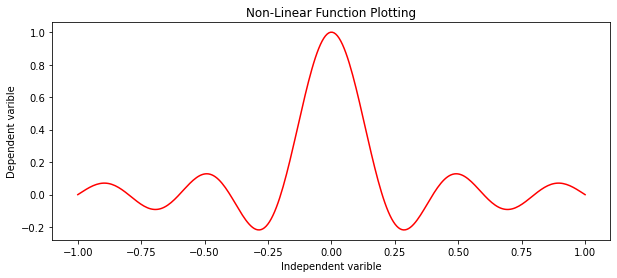

In [5]:
plt.figure(figsize=(10,4))
plt.plot(X, Y, color = "red")
plt.title('Non-Linear Function Plotting')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.savefig(result_folder+'/func1_plot.png')

In [6]:

class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(input_size, 1)
        self.dense_layer9 = nn.Linear(1, 10)
        self.dense_layer10 = nn.Linear(10, 18)
        self.dense_layer11 = nn.Linear(18, 15)
        self.dense_layer12 = nn.Linear(15, 4)
        self.dense_layer13 = nn.Linear(4, output_size)
        
        
    def forward(self,x):
        x = F.leaky_relu(self.input_layer(x))
        x = F.leaky_relu(self.dense_layer9(x))
        x = F.leaky_relu(self.dense_layer10(x))
        x = F.leaky_relu(self.dense_layer11(x))
        x = F.leaky_relu(self.dense_layer12(x))
        x = self.dense_layer13(x)
        
        return x
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
    
    
    

In [7]:
lr = 0.0001
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4

In [8]:
# v2
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm


def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
#     train_history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
#         grad_norm_per_epoch[epoch] = get_grad_norm(model)
        
        if epoch > 900 and epoch%100 ==0:
            print("Comparing result:", (comparing_epoch_loss - result["val_loss"]))
            if (comparing_epoch_loss - result["val_loss"])  < 0.000001:
#                 print("Comparing result:", (comparing_epoch_loss - result["val_loss"]))
                break
            comparing_epoch_loss=result["val_loss"]
        
        # Training Phase 
        for batch in data_loader:
            loss = model.training_step(batch,criterion)
            loss.backward()
            optimizer.step()
            
            grad_norm_per_epoch[epoch] = get_grad_norm(model)
#             if epoch %100 == 0:
#                 print("grad_norm is :", grad_norm_per_epoch[epoch])
            if grad_norm_per_epoch[epoch] == 0.0 :
                return history,grad_norm_per_epoch,model
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
        
#         res2 = evaluate2(model,train_loader)
#         train_history.append(res2)
    return history,grad_norm_per_epoch,model

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =200
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
input_size=1
output_size=1
model_1 = Model1()

In [10]:
result_1 = evaluate(model_1,criterion,data_loader)
result_1

{'val_loss': 0.09491100907325745}

In [11]:
history_1,grad_norm_1,model_1  = fit(num_epochs, lr, model_1, data_loader, criterion,optimizer)

Epoch [0], val_loss: 0.0933
Epoch [1], val_loss: 0.0870
Epoch [2], val_loss: 0.0840
Epoch [3], val_loss: 0.0832
Epoch [4], val_loss: 0.0827
Epoch [5], val_loss: 0.0825
Epoch [6], val_loss: 0.0787
Epoch [7], val_loss: 0.0758
Epoch [8], val_loss: 0.0742
Epoch [9], val_loss: 0.0731
Epoch [10], val_loss: 0.0719
Epoch [11], val_loss: 0.0711
Epoch [12], val_loss: 0.0705
Epoch [13], val_loss: 0.0699
Epoch [14], val_loss: 0.0691
Epoch [15], val_loss: 0.0685
Epoch [16], val_loss: 0.0677
Epoch [17], val_loss: 0.0671
Epoch [18], val_loss: 0.0665
Epoch [19], val_loss: 0.0660
Epoch [20], val_loss: 0.0653
Epoch [21], val_loss: 0.0647
Epoch [22], val_loss: 0.0640
Epoch [23], val_loss: 0.0635
Epoch [24], val_loss: 0.0630
Epoch [25], val_loss: 0.0624
Epoch [26], val_loss: 0.0619
Epoch [27], val_loss: 0.0612
Epoch [28], val_loss: 0.0607
Epoch [29], val_loss: 0.0602
Epoch [30], val_loss: 0.0596
Epoch [31], val_loss: 0.0590
Epoch [32], val_loss: 0.0584
Epoch [33], val_loss: 0.0581
Epoch [34], val_loss: 0.